## Imports

In [2]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler


## Preprocessing & Data Split

In [3]:
# Split the 'valid_time' into date and time
def extract_datetime_features(df):
    df['valid_time'] = pd.to_datetime(df['valid_time']) # Transfer 'valid_time' into datetime type
    df['year'] = df['valid_time'].dt.year
    df['month'] = df['valid_time'].dt.month
    df['day'] = df['valid_time'].dt.day
    df['hour'] = df['valid_time'].dt.hour
    df["season"] = ((df["month"] & 12 + 3) // 3) + 1
    return df.drop(["id"], axis=1)

In [4]:
# Add nearby features
# Add historical data for the specific place, time lag is one hour. Places without last hour's data results in N/A so will need to drop N/A after applying this.
def add_lag_features(df, features, group_cols=['latitude', 'longitude'], lag=1):
    df = df.sort_values(by=group_cols + ['valid_time']).reset_index(drop=True)
    for feat in features:
        df[f'{feat}_lag{lag}'] = df.groupby(group_cols)[feat].shift(lag)
    return df

# Construct a 3*3 window for each spot to compute the average data for the nine neighbors.
def add_spatial_averages(df, features, lat_step=0.25, lon_step=0.25):
    avg_features = []
    for feat in features:
        df_list = []
        for dlat in [-lat_step, 0, lat_step]:
            for dlon in [-lon_step, 0, lon_step]:
                shifted = df[['latitude', 'longitude', 'valid_time', feat]].copy()
                shifted['latitude'] += dlat
                shifted['longitude'] += dlon
                shifted = shifted.rename(columns={feat: f'{feat}_shift_{dlat}_{dlon}'})
                df_list.append(shifted)
        for df_part in df_list:
            df = df.merge(df_part, on=['latitude', 'longitude', 'valid_time'], how='left')
        mean_cols = [f'{feat}_shift_{dlat}_{dlon}' for dlat in [-lat_step, 0, lat_step] for dlon in [-lon_step, 0, lon_step]]
        df[f'{feat}_spatial_mean'] = df[mean_cols].mean(axis=1)
        df = df.drop(columns=mean_cols)
        avg_features.append(f'{feat}_spatial_mean')
    return df


In [5]:
# Define feature sets
standard_features = [
    'tp', 'sp', 'u10', 'v10', 'u100', 'v100', 'tcc', 'ptype',
    'month', 'day', 'hour', 'season'
]

lag_vars = ['tp', 'sp', 'u10', 'v10']
spatial_vars = ['tp', 'sp', 'tcc']

# For consistency, define lag and spatial lag features
lag_features = [f'{var}_lag1' for var in lag_vars]
spatial_lag_features = [f'{var}_lag1_spatial_mean' for var in lag_vars]

final_features = standard_features + lag_features + spatial_vars + spatial_lag_features

# Load dataset and, split valid_time, sampling for model training.
def prepare_dataset(option='standard', path='/cs/datasets/ID5059/Coursework2/data/train.csv'):

    df = pd.read_csv(path).copy()
    df = extract_datetime_features(df)
    df = df.sort_values(by=['latitude', 'longitude', 'valid_time']).reset_index(drop=True)

    if option == 'standard':
        df = df[standard_features + ['t2m']].dropna()
        return df
    if option == 'with_lag':
        df = add_lag_features(df, lag_vars)
        df = df[standard_features + lag_features + ['t2m']].dropna()
        return df
    if option == 'with_lag_spatial':
        df = add_lag_features(df, lag_vars)
        df = add_spatial_averages(df, spatial_vars)
        df = add_spatial_averages(df, lag_features)
        df = df[final_features + ['t2m']].dropna()
        return df
    raise ValueError("Invalid option. Choose from 'standard', 'with_lag', 'with_lag_spatial'")

Model Evaluation Results
Standard Features - RMSE: 1.3763   R²: 0.9210
Nearby Features   - RMSE: 1.3494   R²: 0.9244


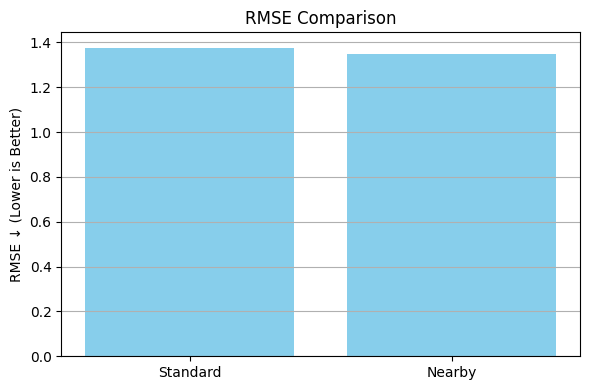

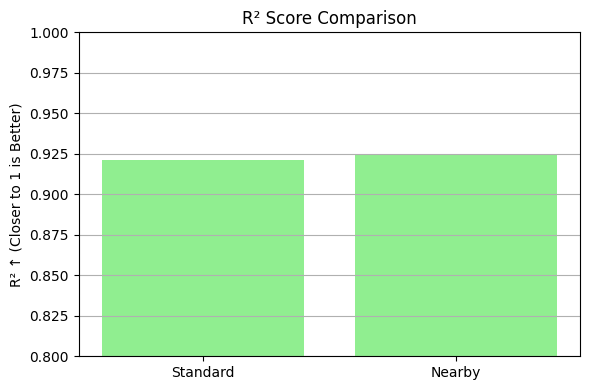

In [6]:
# 1. Load two versions of data and sampling.
df_std_full = prepare_dataset('standard')
df_std = df_std_full.sample(frac=0.1, random_state=42).reset_index(drop=True)
df_lag_full = prepare_dataset('with_lag_spatial')
df_lag = df_lag_full.sample(frac=0.1, random_state=42).reset_index(drop=True)

# 2. Split features and prediction value
X_std, y_std = df_std.drop(columns=['t2m']), df_std['t2m']
X_lag, y_lag = df_lag.drop(columns=['t2m']), df_lag['t2m']

# 3. Split validation set from train set
X_train_std, X_val_std, y_train_std, y_val_std = train_test_split(X_std, y_std, test_size=0.2, random_state=42)
X_train_lag, X_val_lag, y_train_lag, y_val_lag = train_test_split(X_lag, y_lag, test_size=0.2, random_state=42)

# 4. Model training
model_std = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model_std.fit(X_train_std, y_train_std)
pred_std = model_std.predict(X_val_std)

model_lag = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model_lag.fit(X_train_lag, y_train_lag)
pred_lag = model_lag.predict(X_val_lag)

# 5. Calculate scores
rmse_std = np.sqrt(mean_squared_error(y_val_std, pred_std))
r2_std = r2_score(y_val_std, pred_std)

rmse_lag = np.sqrt(mean_squared_error(y_val_lag, pred_lag))
r2_lag = r2_score(y_val_lag, pred_lag)

print("Model Evaluation Results")
print(f"Standard Features - RMSE: {rmse_std:.4f}   R²: {r2_std:.4f}")
print(f"Nearby Features   - RMSE: {rmse_lag:.4f}   R²: {r2_lag:.4f}")

# Comparison chart
models = ['Standard', 'Nearby']
rmse_values = [rmse_std, rmse_lag]
r2_values = [r2_std, r2_lag]

# Plot RMSE
plt.figure(figsize=(6, 4))
plt.bar(models, rmse_values, color='skyblue')
plt.title("RMSE Comparison")
plt.ylabel("RMSE ↓ (Lower is Better)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot R²
plt.figure(figsize=(6, 4))
plt.bar(models, r2_values, color='lightgreen')
plt.title("R² Score Comparison")
plt.ylabel("R² ↑ (Closer to 1 is Better)")
plt.ylim(0.8, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Nearby features do improve model's performance!

## Predition VS. True (Validation set)

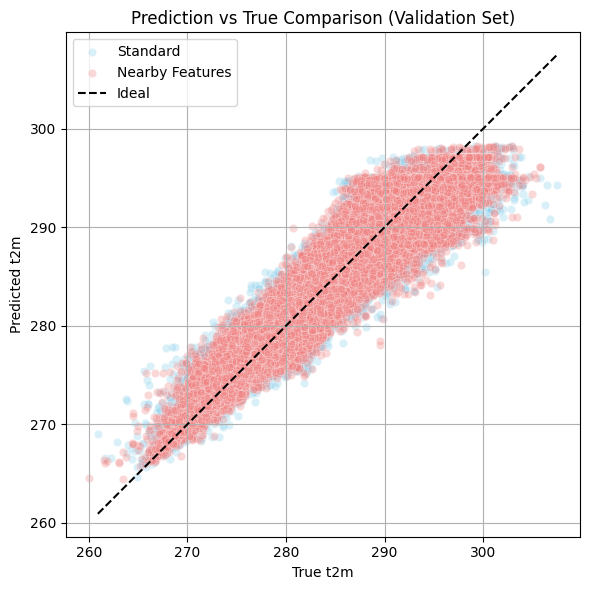

In [7]:
plt.figure(figsize=(6, 6))

# Standard model
sns.scatterplot(x=y_val_std, y=pred_std, label='Standard', alpha=0.3, color='skyblue')

# nearby featured model
sns.scatterplot(x=y_val_lag, y=pred_lag, label='Nearby Features', alpha=0.3, color='lightcoral')

# Perfect prediction line
plt.plot([y_val_std.min(), y_val_std.max()], [y_val_std.min(), y_val_std.max()], 'k--', label='Ideal')

plt.xlabel('True t2m')
plt.ylabel('Predicted t2m')
plt.title('Prediction vs True Comparison (Validation Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



## Feature importances

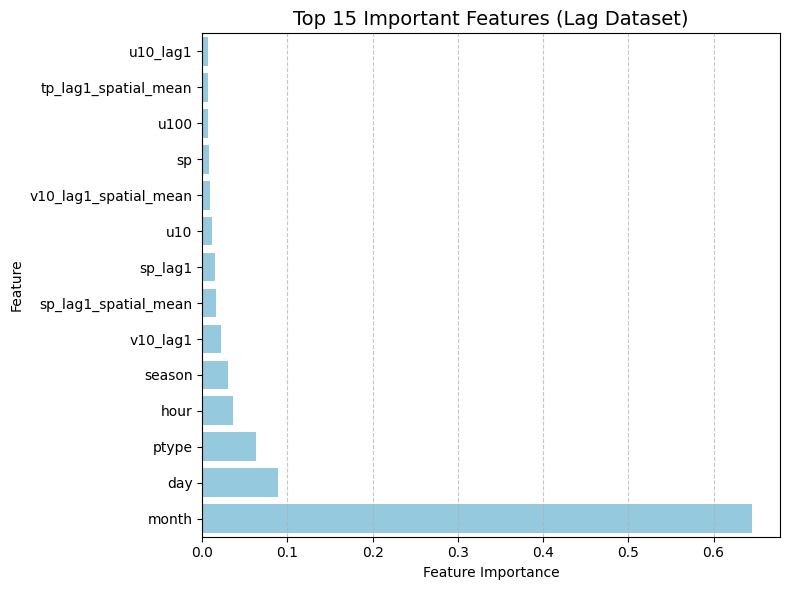

In [8]:
importances = pd.Series(model_lag.feature_importances_, index=X_train_lag.columns)
top_features = importances.sort_values(ascending=True).tail(15)

plt.figure(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, color='skyblue')
plt.title("Top 15 Important Features (Lag Dataset)", fontsize=14)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Save the model

In [9]:
joblib.dump(model_lag, 'randomForest.pkl')

['randomForest.pkl']

## Fine tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Parameters
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Base model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Settings
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit
search.fit(X_train_lag, y_train_lag)

# Find the best model
best_model = search.best_estimator_

# Evaluation
y_pred_best = best_model.predict(X_val_lag)
rmse_best = np.sqrt(mean_squared_error(y_val_lag, y_pred_best))
r2_best = r2_score(y_val_lag, y_pred_best)

print("✅ Tuned Model Performance")
print(f"RMSE: {rmse_best:.4f}")
print(f"R²: {r2_best:.4f}")
print("Best Parameters:", search.best_params_)

joblib.dump(best_model, 'rf_lag_tuned.pkl')
print("Best Model Saved as 'rf_lag_tuned.pkl' ")

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/yf41/.local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


## Final Model trained on the whole train set

In [ ]:
# 1. Features and target value
X_lag_full = df_lag_full.drop(columns=['t2m'])
y_lag_full = df_lag_full['t2m']

# 2. Construct final model（using search.best_params）
final_model = RandomForestRegressor(**search.best_params_, random_state=42, n_jobs=-1)

# 3. Train and save final model
final_model.fit(X_lag_full, y_lag_full)
joblib.dump(final_model, 'randomForest_final_lagged.pkl')
print("Model trained on full dataset and saved as 'rf_final_model.pkl'")

## Make prediction on test set

In [75]:
# Read and process test set
test_df = pd.read_csv('/cs/datasets/ID5059/Coursework2/data/test.csv')
test_df = extract_datetime_features(test_df)
subset = test_df[(test_df['latitude'] == 56.25) & (test_df['longitude'] == -2.75)].copy()

In [76]:

# Construct the lagging features as in training
subset = add_lag_features(subset, base_vars, group_cols=['latitude', 'longitude'])
subset = add_spatial_averages(subset, spatial_vars)
subset = add_spatial_averages(subset, spatial_lag_vars)
subset = subset.dropna()

# Only select the data required
X_test = subset[feature_cols]  # Ensure that the features are the same

# Load the model and predict
model = joblib.load('randomForest.pkl')
y_pred_test = model.predict(X_test)

# Save the predicting result
submission = pd.DataFrame({
    'valid_time': subset['valid_time'],
    'prediction': y_pred_test
}) # Meet the requirement
submission.to_csv('prediction_randomForest.csv', index=False)


KeyError: "['weekday'] not in index"

## Summary

In [57]:
print("Validation Set Performance:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_val, model.predict(X_val))):.4f}")
print(f"R² : {r2_score(y_val, model.predict(X_val)):.4f}")

Validation Set Performance:
RMSE: 1.4283
R² : 0.6919
